# Gaussian Process

In [1]:
import autoroot
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray as xr
import einx
import cola
from oi_toolz._src.ops.kernels import kernel_rbf, gram

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

# plot
x_plot = jnp.linspace(-3.5, 3.5, 50).reshape(-1, 1)
y_plot = f(x_plot)

# test
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

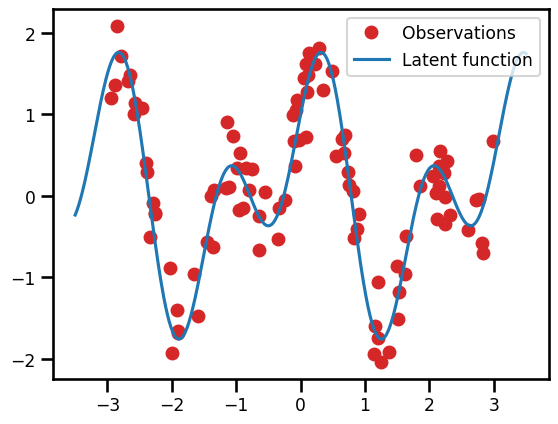

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.legend(loc="best")
plt.show()

In [4]:
length_scale = 0.5
variance = 1.0
noise = 0.01

In [5]:
# calculate kernel matrix
Kxx = cola.ops.Dense(
    gram(
        kernel_rbf, x_plot, x_plot, length_scale=length_scale, variance=variance
    )
)
K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))

## Gaussian Distribution

In [6]:
loc = jnp.zeros_like(x_plot)

In [7]:
loc.shape, y_plot.shape

((50, 1), (50, 1))

In [37]:
# initialize distribution
mvn_dist = dist.MultivariateNormal(
    loc=loc.squeeze(), covariance_matrix=K.to_dense()).to_event()
# tricks to make it multi-output
# mvn_dist = mvn_dist.expand_by(y.T.shape[:-1]).to_event(y.T.ndim - 1)
mvn_dist.batch_shape, mvn_dist.event_shape

((), (50,))

In [38]:
mvn_dist.log_prob(y_plot.T)

Array([7.67886595], dtype=float64)

### Masks

In [41]:
mask = jnp.ones_like(y_plot)

mvn_dist_masked = mvn_dist.mask(mask.astype(bool).squeeze()).to_event(1)

mvn_dist_masked.batch_shape, mvn_dist_masked.event_shape

((), (50, 50))

In [21]:
y_plot.T.shape

(1, 50)

In [22]:
with numpyro.handlers.mask(mask=mask.astype(bool)):
    loss = mvn_dist_masked.log_prob(y_plot.T)

In [23]:
loss

Array(383.94329769, dtype=float64)

In [142]:
out = numpyro.sample("obs", mvn_dist, obs=y_plot.T)
out.shape, out

((1, 50),
 Array([[-2.36705101e-01,  1.49229852e-01,  7.02757904e-01,
          1.26715651e+00,  1.66326318e+00,  1.74638908e+00,
          1.45381928e+00,  8.27683296e-01,  5.69019147e-03,
         -8.17662038e-01, -1.44747994e+00, -1.74499079e+00,
         -1.66666255e+00, -1.27390085e+00, -7.10576998e-01,
         -1.55767631e-01,  2.33152357e-01,  3.68981040e-01,
          2.59447970e-01,  6.32244339e-04, -2.58534000e-01,
         -3.68995121e-01, -2.34341730e-01,  1.53584987e-01,
          7.07970408e-01,  1.27165611e+00,  1.66553572e+00,
          1.74546442e+00,  1.44959973e+00,  8.21006364e-01,
         -1.89673352e-03, -8.24346789e-01, -1.45171285e+00,
         -1.74593052e+00, -1.66440259e+00, -1.26940799e+00,
         -7.05364038e-01, -1.51405723e-01,  2.35525979e-01,
          3.69004251e-01,  2.57617028e-01, -1.89672594e-03,
         -2.60358925e-01, -3.68962002e-01, -2.31957866e-01,
          1.57953644e-01,  7.13183793e-01,  1.27614218e+00,
          1.66778309e+00,  1.7

In [140]:
out_mask = numpyro.sample("obs", mvn_dist, obs=y_plot.T, obs_mask=mask.astype(bool))
out_mask.shape

(1, 50)

In [141]:
out_mask

Array([[-2.36705101e-01,  1.49229852e-01,  7.02757904e-01,
         1.26715651e+00,  1.66326318e+00,  1.74638908e+00,
         1.45381928e+00,  8.27683296e-01,  5.69019147e-03,
        -8.17662038e-01, -1.44747994e+00, -1.74499079e+00,
        -1.66666255e+00, -1.27390085e+00, -7.10576998e-01,
        -1.55767631e-01,  2.33152357e-01,  3.68981040e-01,
         2.59447970e-01,  6.32244339e-04, -2.58534000e-01,
        -3.68995121e-01, -2.34341730e-01,  1.53584987e-01,
         7.07970408e-01,  1.27165611e+00,  1.66553572e+00,
         1.74546442e+00,  1.44959973e+00,  8.21006364e-01,
        -1.89673352e-03, -8.24346789e-01, -1.45171285e+00,
        -1.74593052e+00, -1.66440259e+00, -1.26940799e+00,
        -7.05364038e-01, -1.51405723e-01,  2.35525979e-01,
         3.69004251e-01,  2.57617028e-01, -1.89672594e-03,
        -2.60358925e-01, -3.68962002e-01, -2.31957866e-01,
         1.57953644e-01,  7.13183793e-01,  1.27614218e+00,
         1.66778309e+00,  1.74450961e+00]], dtype=float6

### Example

In [231]:
batch_dims = 5
dims = 10
data = jr.normal(key=key, shape=(batch_dims, dims))
masked_array = jnp.where(data > 0, True, False)
masked_array.shape

(5, 10)

In [232]:
loc = jnp.zeros((batch_dims,dims))
scale = jnp.ones((dims,))

my_dist = dist.Normal(loc,scale).to_event(1)

my_dist.batch_shape, my_dist.event_shape

((5,), (10,))

In [238]:
masked_dist = my_dist.mask(masked_array[:,0])

masked_dist.batch_shape, masked_dist.event_shape

((5,), (10,))

In [182]:
data.shape, masked_array.shape

((10, 2), (10, 2))

In [185]:
loc = jnp.zeros(dims)
scale = jnp.ones(dims)
my_dist = dist.Normal(loc,scale)

my_dist.batch_shape, my_dist.event_shape

((10, 2), ())

In [186]:
masked_dist = my_dist.mask(masked_array)

masked_dist.batch_shape, masked_dist.event_shape

((10, 2), ())

In [187]:
masked_dist.log_prob(data)

Array([[-0.97478029,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -1.03569457],
       [ 0.        ,  0.        ],
       [-1.08776799,  0.        ],
       [-0.95129093, -0.99237382],
       [-2.3511442 , -1.41500176],
       [-1.70799686, -1.17224567],
       [ 0.        , -1.25405968],
       [ 0.        , -0.99853663]], dtype=float64)

In [206]:
dims + dims

(10, 2, 10, 2)

In [ ]:


mvn_dist = dist.MultivariateNormal(
    loc=loc, covariance_matrix=K.to_dense()
)

In [15]:
mvn_dist_masked = mvn_dist.mask(mask[None,:])

mvn_dist_masked.batch_shape, mvn_dist_masked.event_shape

((1, 50), (1, 50))

In [18]:
mask.shape, y_plot.T.shape

((50,), (1, 50))

In [21]:
numpyro.sample("obs", mvn_dist.to_event(0), obs=y_plot.T, obs_mask=mask[None,:].astype(bool)).log_prob(

Array([[-2.36705101e-01,  1.49229852e-01,  7.02757904e-01,
         1.26715651e+00,  1.66326318e+00,  1.74638908e+00,
         1.45381928e+00,  8.27683296e-01,  5.69019147e-03,
        -8.17662038e-01, -1.44747994e+00, -1.74499079e+00,
        -1.66666255e+00, -1.27390085e+00, -7.10576998e-01,
        -1.55767631e-01,  2.33152357e-01,  3.68981040e-01,
         2.59447970e-01,  6.32244339e-04, -2.58534000e-01,
        -3.68995121e-01, -2.34341730e-01,  1.53584987e-01,
         7.07970408e-01,  1.27165611e+00,  1.66553572e+00,
         1.74546442e+00,  1.44959973e+00,  8.21006364e-01,
        -1.89673352e-03, -8.24346789e-01, -1.45171285e+00,
        -1.74593052e+00, -1.66440259e+00, -1.26940799e+00,
        -7.05364038e-01, -1.51405723e-01,  2.35525979e-01,
         3.69004251e-01,  2.57617028e-01, -1.89672594e-03,
        -2.60358925e-01, -3.68962002e-01, -2.31957866e-01,
         1.57953644e-01,  7.13183793e-01,  1.27614218e+00,
         1.66778309e+00,  1.74450961e+00]], dtype=float6

In [10]:

# with numpyro.handlers.mask(mask=mask.astype(bool)):
#     print(mvn_dist.log_prob(y_plot.T))
#     out = numpyro.sample("obs", mvn_dist, obs=y_plot.T, obs_mask=mask.astype(bool))
#     print(out)
    

In [11]:
mask = jnp.ones_like(y_plot.squeeze())
mask.shape

(50,)

In [12]:
mvn_dist_masked = mvn_dist.mask(mask)

mvn_dist_masked.batch_shape, mvn_dist_masked.event_shape

((50,), (1, 50))

In [13]:
mvn_dist_masked.batch_shape, mvn_dist_masked.event_shape

((50,), (1, 50))

In [14]:
# log probability
mvn_dist_masked.log_prob(y_plot.T)

Array([7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595,
       7.67886595, 7.67886595, 7.67886595, 7.67886595, 7.67886595],      dtype=float64)

#### From Scratch

$$
\begin{aligned}
\text{Log-Likelihood}: && &&
\mathcal{L}(\boldsymbol{\theta}) &= 
\text{Quadratic Form} + \text{Log Determinant} + \text{Constant}\\
\text{Quadratic Form}: && &&
&= \frac{1}{2}\mathbf{y}^\top\left(\mathbf{K}+\sigma^2_n\mathbf{I}\right)^{-1}\mathbf{y} \\
\text{Log Determinant}: && &&
&= \frac{1}{2}\log | \mathbf{K}+\sigma^2_n\mathbf{I} | \\
\text{Constant}: && &&
&= \frac{n}{2}\log 2\pi
\end{aligned}
$$

In [15]:
from oi_toolz._src.ops.linalg import calculate_quadratic_form_psd, log_det_psd

In [18]:
algorithm = "cholesky"
t1 = calculate_quadratic_form_psd(K, y_plot-loc, algorithm=algorithm)
t2 = log_det_psd(K, log_algorithm=algorithm)
t3 = jnp.log(2*jnp.pi)*y_plot.shape[0]

In [19]:
lld = t1 + t2 + t3
-lld, -lld*0.5

(Array([[15.35773191]], dtype=float64), Array([[7.67886595]], dtype=float64))

#### GPJAX Version

In [20]:
from cola.linalg.decompositions.decompositions import Cholesky
# diff, y - µ
diff = y_plot - loc

# compute the pdf, -1/2[ n log(2π) + log|Σ| + (y - µ)ᵀΣ⁻¹(y - µ) ]
loss = -0.5 * (
    y_plot.shape[0] * jnp.log(2.0 * jnp.pi)
    + cola.logdet(K, Cholesky(), Cholesky())
    + diff.T @ cola.solve(K, diff, Cholesky())
)
loss

Array([[7.67886595]], dtype=float64)

#### BayesNewton Version

In [158]:
import math
from jax.scipy.linalg import cholesky, cho_factor, cho_solve

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1


def mvn_logpdf(x, mean, cov, mask=None):
    """
    evaluate a multivariate Gaussian (log) pdf
    """
    x = x.reshape(-1, 1)
    mean = mean.reshape(-1, 1)
    if mask is not None:
        
        # build a mask for computing the log likelihood of a partially observed multivariate Gaussian
        maskv = mask.reshape(-1, 1)
        print(x.shape, maskv.shape)
        x = jnp.where(maskv, 0., x)
        mean = jnp.where(maskv, 0., mean)
        cov_masked = jnp.where(maskv + maskv.T, 0., cov)  # ensure masked entries are independent
        cov = jnp.where(jnp.diag(mask), INV2PI, cov_masked)  # ensure masked entries return log like of 0

    n = mean.shape[0]
    cho, low = cho_factor(cov, lower=True)
    log_det = 2 * jnp.sum(jnp.log(jnp.abs(jnp.diag(cho))))
    diff = x - mean
    scaled_diff = cho_solve((cho, low), diff)
    distance = diff.T @ scaled_diff
    return jnp.squeeze(-0.5 * (distance + n * LOG2PI + log_det))

In [159]:
mask = np.zeros_like(loc[:, 0])
mask[1:] = 1.0
mvn_logpdf(y_plot, loc, K.to_dense(), mask=mask)

(50, 1) (50, 1)


Array(-0.95165098, dtype=float64)

In [238]:
key, subkey = jr.split(key)

samples = mvn_dist.sample(key=key, sample_shape=(10,))

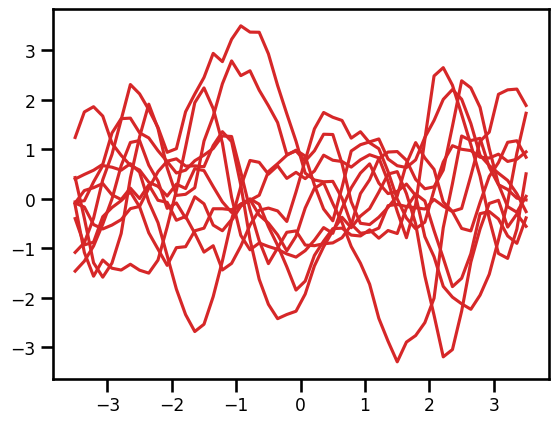

In [239]:
fig, ax = plt.subplots()
ax.plot(x_plot, samples.T, label="Observations", color="tab:red")
# ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
# ax.legend(loc="best")
plt.show()

In [241]:
from oi_toolz._src.ops.linalg import calculate_quadratic_form_psd

In [ ]:
def predict(x1, x2, kernel):
    # calculate kernel
    
    return None

In [ ]:
def predicted_mean_std(ls,uscale,noise):
    kernel = gram(kernel_rbf, train_x, train_y, length_scale=0.1, variance=0.1)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    Kzx = cola.ops.Dense(kernel(test_x, train_x))
    Kzz = cola.ops.Dense(kernel(test_x, test_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K, alg=Cholesky())
    mu = Kzx@invK@train_y
    Sigma = Kzz - Kzx@invK@Kzx.T
    std = jnp.sqrt(cola.diag(Sigma))
    return mu,std

In [92]:
Kzx = cola.ops.Dense(gram(kernel_rbf, xtest, y, length_scale=length_scale, variance=variance))
Kzz = cola.ops.Dense(gram(kernel_rbf, xtest, ytest, length_scale=length_scale, variance=variance))
K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))

In [106]:
from cola.linalg import CG, Cholesky, Auto

In [109]:
CG()

cola.linalg.inverse.cg.CG

In [103]:
K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))

In [ ]:
cola.inv()

In [111]:
# %%timeit

invK = cola.inv(K, alg=CG(pbar=True))

In [105]:
%%timeit

invK = cola.inv(K, alg=Cholesky())

1.22 ms ± 43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [73]:
mu = Kzx @ invK @ y

In [74]:
Sigma = Kzz - Kzx @ invK @ Kzx.T



In [75]:
std = jnp.sqrt(cola.diag(Sigma))

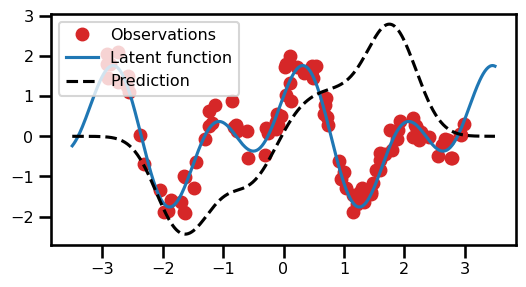

In [76]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
plt.plot(xtest, mu, label="Prediction", linestyle="--", color="black")
ax.legend(loc="best")
plt.show()

## Loss Function

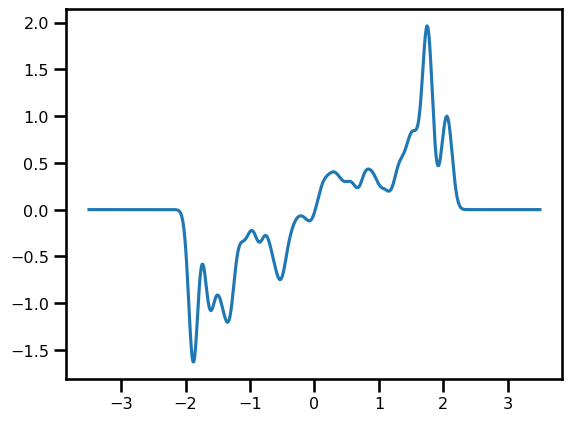

In [48]:
plt.plot(xtest, mu)

In [ ]:
def predicted_mean_std(ls,uscale,noise):
    kernel = gram(kernel_rbf, train_x, train_y, length_scale=0.1, variance=0.1)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    Kzx = cola.ops.Dense(kernel(test_x, train_x))
    Kzz = cola.ops.Dense(kernel(test_x, test_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K, alg=Cholesky())
    mu = Kzx@invK@train_y
    Sigma = Kzz - Kzx@invK@Kzx.T
    std = jnp.sqrt(cola.diag(Sigma))
    return mu,std

In [ ]:
# compute the MLL
y = train_y
alg = Cholesky()
def NLL(params, key):
    ls,uscale,noise = params
    kernel = rbf(ls, uscale)
    Kxx= cola.ops.Dense(kernel(train_x, train_x))
    K = cola.PSD(Kxx + noise * cola.ops.I_like(Kxx))
    invK = cola.inv(K,alg)
    minus2MLL =y.T@(invK@y)+cola.logdet(K,alg)+jnp.log(2*jnp.pi)*y.shape[0]
    return minus2MLL/(2*y.shape[0])

In [30]:
def get_diag_and_offdiag_components(num_latents, zeros, i, noise_cov):
    temp_vec = zeros.at[i].add(1.)
    temp_mat = temp_vec.reshape(num_latents, num_latents)
    return jnp.kron(jnp.diag(noise_cov), temp_mat)  # block-diag


def blocktensor_to_blockdiagmatrix(blocktensor):
    """
    Convert [N, D, D] tensor to [ND, ND] block-diagonal matrix
    """
    print(type(blocktensor))
    N = blocktensor.shape[0]
    D = blocktensor.shape[1]
    diag_and_offdiag_components = jax.vmap(get_diag_and_offdiag_components, in_axes=(None, None, 0, 1))(
        D, jnp.zeros(D ** 2), jnp.arange(D ** 2), blocktensor.reshape(N, -1)
    )
    return jnp.sum(diag_and_offdiag_components, axis=0)

In [31]:
num_dims, num_samples = 10, 25
D = jr.normal(key, shape=(num_samples, num_dims, num_dims))

In [38]:
D.shape

(25, 10, 10)

In [39]:
25*10 

250

In [32]:
out = blocktensor_to_blockdiagmatrix(D)
out.shape

<class 'jaxlib.xla_extension.ArrayImpl'>


(250, 250)

In [37]:
out_ = einx.rearrange("(Nx Ny) Dx Dy -> (Nx Dx) (Ny Dy)", D)

SolveValueException: Failed to solve values of expressions. Found no unique solutions for {'Ny', 'Nx'}
Input:
    '(Nx Ny) Dx Dy = 25 10 10'
    '(Nx Dx) (Ny Dy) = None'


In [91]:
from sklearn.utils.extmath import _deterministic_vector_sign_flip

array([4.33195133, 2.37824884, 1.98186076])

array([4.33195133, 2.37824884, 1.98186076])

In [166]:
num_space = 5
num_time = 3
X = jr.normal(key, shape=(num_space, num_time))

U, S, V_T = np.linalg.svd(X, full_matrices=True, )

assert U.shape == (num_space, num_space)
assert V_T.T.shape == (num_time,num_time)

# calculate from eigenvalues
eigs_, V_ = np.linalg.eig(X.T @ X)

idx = eigs_.argsort()[::-1] 
eigs_ = eigs_[idx]
V_ = V_[:, idx]

U_ = X @ V_ @ np.diag(np.sqrt(eigs_))

np.testing.assert_array_almost_equal(np.abs(V_.real), np.abs(V_T.T), decimal=5)
# np.testing.assert_array_almost_equal(np.abs(U.real[:, :num_time]), np.abs(U_), decimal=5)


In [162]:
S, np.sqrt(eigs_)

(array([3.61937946, 2.60267138, 1.76582111]),
 array([3.61937946, 2.60267138, 1.76582111]))

In [163]:
V_T, V_

(array([[ 0.08830373, -0.1615574 , -0.9829047 ],
        [-0.57191262, -0.81612866,  0.08276449],
        [-0.81554792,  0.55482719, -0.16446392]]),
 array([[-0.08830373,  0.57191262, -0.81554792],
        [ 0.1615574 ,  0.81612866,  0.55482719],
        [ 0.9829047 , -0.08276449, -0.16446392]]))

In [168]:
_deterministic_vector_sign_flip(V_), _deterministic_vector_sign_flip(V_T)

(array([[ 0.08830373, -0.57191262,  0.81554792],
        [ 0.1615574 ,  0.81612866,  0.55482719],
        [ 0.9829047 , -0.08276449, -0.16446392]]),
 array([[-0.08830373,  0.1615574 ,  0.9829047 ],
        [ 0.57191262,  0.81612866, -0.08276449],
        [ 0.81554792, -0.55482719,  0.16446392]]))

In [110]:
U.shape

(10, 10)

In [83]:
V_

Array([[-0.36059805+0.j, -0.81062   +0.j, -0.46137214+0.j],
       [-0.40217346+0.j,  0.5814362 +0.j, -0.70724003+0.j],
       [-0.84156138+0.j,  0.06947775+0.j,  0.53567461+0.j]],      dtype=complex128)

In [84]:
V_T.T

Array([[-0.36059805, -0.81062   ,  0.46137214],
       [-0.40217346,  0.5814362 ,  0.70724003],
       [-0.84156138,  0.06947775, -0.53567461]], dtype=float64)

In [78]:
U

Array([[-0.01334079, -0.06087154,  0.06785393,  0.5676744 ,  0.08679848,
        -0.14618006, -0.26459988, -0.43315342, -0.52793453, -0.3224994 ],
       [-0.43679642, -0.15416298,  0.23965756, -0.36195574,  0.06722072,
        -0.40951172,  0.50112172, -0.04168808, -0.20035115, -0.3630083 ],
       [-0.5382465 ,  0.4268092 ,  0.02152814,  0.08229093,  0.17503937,
        -0.24849123, -0.31031004,  0.38303924, -0.22852321,  0.36505951],
       [ 0.14623529,  0.54302384,  0.34976227,  0.49116005, -0.06251679,
        -0.05416556,  0.47744525,  0.10666809,  0.25007336, -0.10703979],
       [ 0.20707538, -0.0037759 ,  0.04784935, -0.05286516,  0.96985825,
         0.05034768,  0.052038  , -0.00860068,  0.07728776, -0.01029601],
       [-0.42583772,  0.06530563,  0.20524951, -0.01505597,  0.04125104,
         0.8521811 ,  0.08140926, -0.04824893, -0.14245701, -0.12198227],
       [-0.1668161 , -0.24361647, -0.62011027,  0.37589767,  0.06951256,
         0.05650989,  0.52849338,  0.08227434

In [52]:
U.shape, S.shape, V.shape, V_.shape

((100, 100), (10,), (10, 10), (10,))

In [45]:
import jax.scipy as jsp

In [ ]:
jsp.linalg.svd()

In [59]:
(S, S)

(Array([12.41957813, 11.95950499, 10.89607252, 10.69730362, 10.09412493,
         9.67609601,  9.3039235 ,  9.04484626,  7.75723238,  6.53840263],      dtype=float64),
 Array([12.41957813, 11.95950499, 10.89607252, 10.69730362, 10.09412493,
         9.67609601,  9.3039235 ,  9.04484626,  7.75723238,  6.53840263],      dtype=float64))

In [58]:
U.shape == (S, S)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()